# Predicting the Success of Kickstarter Campaigns Based on Set Goal and Category
### Anja Subasic and Marissa Le Coz

### Project Proposal

Goals: In this project we will use machine learning and statistical data analysis to identify an optimal funding goal for people who start Kickstarter campaigns, depending on the category they chose for their campaign. Previous work in this area used features such as number of backers, total funds pledged, currency, deadline and others in order to predict the success of a Kickstarter campaign when it is first launched. We plan to look at different categories and subcategories to see whether a campaign is successful based on the category it belongs to, in addition to other important factors identified by previous work. Kickstarter offers fifteen different categories for users to select for their projects, including Film & Video, Food, Design, Technology and others. We hypothesize that the amount of money people are willing to pledge to a campaign varies by the category of the project.

Questions: The main question this project will try to answer is whether the amount of money people are willing to pledge in a Kickstarter campaign varies by category and how. For example, we will try to identify what goal a user should set for their campaign, given that their product is in the Food category, in order for it to be successful. 

Dataset: We are going to use two Kickstarter projects datasets we found on Kaggle.com, which contain data about over 300,000 Kickstarter projects created between 2010 and 2017. Common features in the datasets include project id, name (title) of the project, category, sub-category, currency, deadline (date after which the campaign ends), goal (monetary goal), launch date, amount pledged, state (successful, cancelled or failed), number of backers and country. We will use state of the project as a dependent variable and value we are trying to predict, and a set of binary classifiers to predict whether a campaign is successful. We plan to drop feature vectors with the state “cancelled”, since we are only interested in campaigns that reached their deadline. We also plan to isolate feature vectors (each feature vector corresponds to one Kickstarter project, as shown in the figure below) for each category. 

https://www.kaggle.com/kemical/kickstarter-projects/data 


![title](kaggle_data.png)
Sample from the Kickstarter Projects dataset from Kaggle.com

Related Work: 

[1] Predicting the Success of Kickstarter Campaigns - https://towardsdatascience.com/predicting-the-success-of-kickstarter-campaigns-3f4a976419b9 

Although this study was not presented as a formal academic paper, we felt that its work was very relevant to our research questions. The author, Adebola Lamidi, ran Machine Learning algorithms on 45,957 Kickstarter campaign samples from 2009-2011 to discover the attributes of successful projects. His dataset was different from the one we plan to use, although it had many of the same features as ours. His major findings were as follows. First, successful projects had shorter durations (i.e., the amount of time that the person who starts the Kickstarter campaign has set to reach his/her funding goal). Second, campaigns with lower funding goals were more successful, which is unsurprising (in fact, unsuccessful campaigns asked for three times more funding than successful campaigns, on average). Third, campaigns with more comments and updates were more successful, also unsurprisingly. Lamidi also determined which campaign categories were the most successful. Kickstarter campaigns in the Dance category were the most successful, with a 75% success rate. The Theater category was the second most successful, with a 70% success rate. Music came in at third, with a 68% success rate.

While Limidi explores what makes a successful Kickstarter campaign in general, we wish to explore what makes a successful Kickstarter campaign for each campaign category. We think that, although it is interesting to know which categories perform the best on Kickstarter, it is not terribly useful. If you have an idea to post on Kickstarter, the category is already more or less determined by your idea. We want to help people with ideas for Kickstarter to maximize their chances of success.

[2] Using Language to Predict Kickstarter Success
https://web.stanford.edu/class/cs221/2017/restricted/p-final/rtuason/final.pdf 

While most projects using Kickstarter data focus on predicting the success of a campaign based on features such as campaign duration, target amount, etc., Sawhney, Tran, and Tuason take a different, NLP-based approach. They analyze the text of a campaign using sentiment analysis and make predictions about the success of the campaign using this information. Their classifier achieved a 70% success rate in predicting the outcome of Kickstarter campaigns. They considered examining the linguistic features of campaign content by campaign category, but they concluded that the 10,000 samples they had from each category were not sufficient to draw any reliable conclusions (although that does sound pretty high…). Hence, they did not share any category-by-category results. As we analyze Kickstarter campaigns by category for our project, we will have to assess whether the number of samples we have per category is sufficient for drawing reliable conclusions. 


### Preliminary Work: Exploring and Visualizing the Data

In [88]:
import pandas as pd
from datetime import datetime

In [89]:
# Getting the data in a dataframe

dataframe = pd.DataFrame.from_csv('Project Files/ks-projects-201801.csv')

Pre-processing: add a duration feature, add difference between goal and pledged feature, get rid of canceled campaigns

In [90]:
# remove canceled campaigns
df_successful = dataframe[dataframe['state'] == 'successful']
df_failed = dataframe[dataframe['state'] == 'failed']
dataframe_filtered = pd.concat([df_successful, df_failed])

# add feature for difference between goal and pledged
# is positive if pledge more than goal. is negative if didn't meet goal
dataframe_filtered['pledged_minus_goal'] = dataframe_filtered['usd_pledged_real'] - dataframe_filtered['usd_goal_real']

# add duration feature

duration_list = []
for index, row in dataframe_filtered.iterrows():
    
    # get deadline datetime
    deadline_timestamp = row['deadline']
    deadline_components = deadline_timestamp.split("-")
    deadline = datetime(int(deadline_components[0]), int(deadline_components[1]), int(deadline_components[2]))
    
    # get launch datetime
    launch_timestamp = row['launched']
    launch_components = launch_timestamp.split(" ")
    launch_components = launch_components[0].split("-")
    launch = datetime(int(launch_components[0]), int(launch_components[1]), int(launch_components[2]))
    
    # simply subtract deadline and launch (you can subtract datetimes to get the duration)
    dur = deadline - launch
    dur_just_days = str(dur).split(" ")[0]
    duration_list.append(dur_just_days)

# add this list as a column of the dataframe
duration_series = pd.Series(duration_list)
dataframe_filtered['duration'] = duration_series.values # duration given in days


In [91]:
print dataframe_filtered

                                                         name  \
Id                                                              
1000014025                               Monarch Espresso Bar   
1000023410  Support Solar Roasted Coffee & Green Energy!  ...   
100005484                                    Lisa Lim New CD!   
1000057089  Tombstone: Old West tabletop game and miniatur...   
1000070642                Mike Corey's Darkness & Light Album   
1000072011              CMUK. Shoes: Take on Life Feet First.   
1000091520                        The Book Zoo - A Mini-Comic   
1000102741  Matt Cavenaugh & Jenny Powers make their 1st a...   
1000104688                                Permaculture Skills   
1000104953  Rebel Army Origins: The Heroic Story Of Major ...   
100011318                       My Moon - Animated Short Film   
1000117861                  Ledr workbook: one tough journal!   
1000120151            Feather Cast Furled Fly Fishing Leaders   
100012079             Chr

In [92]:
dataframe_filtered.to_csv("kickstarter_data_cleaned.csv")

Visualize the number of samples from each category to see what we’ve got to work with. Is there enough data from each category to be able to do a reliable analysis on each? Are there certain categories we should exclude? What are the most popular categories, and is there are relationship between category and success?

In [93]:
import seaborn as sns
import matplotlib as plt

sns.set(style="darkgrid");
sns.set(font_scale = 1.5);
plt.rcParams['figure.figsize']=(20,10);
ax = sns.countplot(x="main_category", data=dataframe, order = dataframe['main_category'].value_counts().index);
ax.set_title("Project Popularity by Main Category (15 Kickstarter Categories)", fontsize=30);
ax.set(xlabel='Category');
ax.set(ylabel='Projects');


What subcategories are there, and how many samples do we have from each?

In [94]:
sns.set(style="darkgrid");
sns.set(font_scale = 1.5);
plt.rcParams['figure.figsize']=(20,10);
ax = sns.countplot(x="category", data=dataframe, order = dataframe['category'].value_counts().index);
ax.set_title("Project Popularity by Subcategory", fontsize=30);
ax.set_xticklabels([])
ax.set(xlabel='Category');
ax.set(ylabel='Projects');


In [95]:
sns.set(style="darkgrid");
sns.set(font_scale = 1.5);
plt.rcParams['figure.figsize']=(20,10);
ax = sns.countplot(x="category", data=dataframe, order = dataframe['category'].value_counts().iloc[:10].index);
ax.set_title("Project Popularity - Top 10 Subcategories", fontsize=30);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(xlabel='Category');
ax.set(ylabel='Projects');

How does the goal amount impact success? Per category, represent the percent success rate and the percent fail rate for each bucket of dollar amounts.

In [96]:
# Find where the majority of the projects lie in terms of goal amount
from matplotlib import pyplot as plt

goals_df = dataframe_filtered['goal']
plt.hist(goals_df, 10)
# goals_df.hist(bins=5)
# plt.show()

(array([  3.31561000e+05,   3.20000000e+01,   2.20000000e+01,
          9.00000000e+00,   1.30000000e+01,   4.00000000e+00,
          1.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          3.00000000e+01]),
 array([  1.00000000e-02,   1.00000000e+07,   2.00000000e+07,
          3.00000000e+07,   4.00000000e+07,   5.00000000e+07,
          6.00000000e+07,   7.00000000e+07,   8.00000000e+07,
          9.00000000e+07,   1.00000000e+08]),
 <a list of 10 Patch objects>)

In [97]:
dataframe_modified = dataframe_filtered.sort_values("goal", inplace=False, ascending=False)
max_goal = dataframe_modified['goal'].iloc[0]
print max_goal # this will help us determine buckets

100000000.0


In [98]:
# product_design_df = dataframe_filtered[dataframe_filtered['category'] == 'Product Design']
# documentary_df = dataframe_filtered[dataframe_filtered['category'] == 'Documentary']
# music_df = dataframe_filtered[dataframe_filtered['category'] == 'Music']
# tabletop_games_df = dataframe_filtered[dataframe_filtered['category'] == 'Tabletop Games']
# shorts_df = dataframe_filtered[dataframe_filtered['category'] == 'Shorts']
# video_games_df = dataframe_filtered[dataframe_filtered['category'] == 'Video Games']
# food_df = dataframe_filtered[dataframe_filtered['category'] == 'Food']
# film_and_vid_df = dataframe_filtered[dataframe_filtered['category'] == 'Film & Video']
# fiction_df = dataframe_filtered[dataframe_filtered['category'] == 'Fiction']
# fashion_df = dataframe_filtered[dataframe_filtered['category'] == 'Fashion']

100000000.0


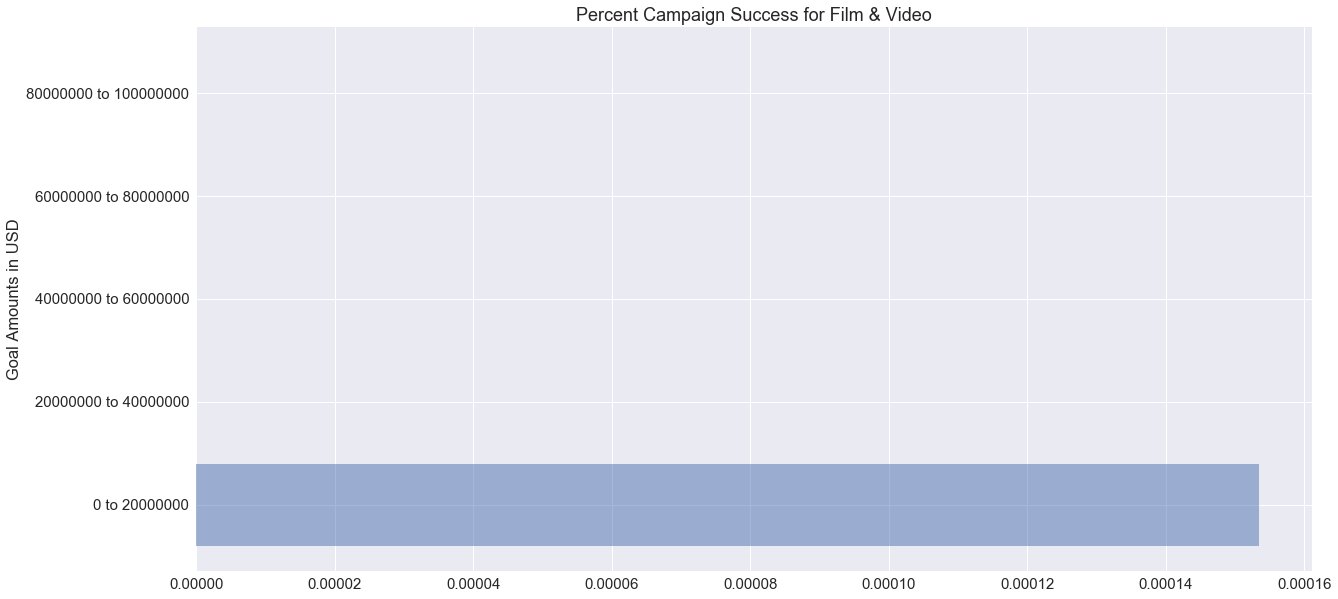

50000000.0


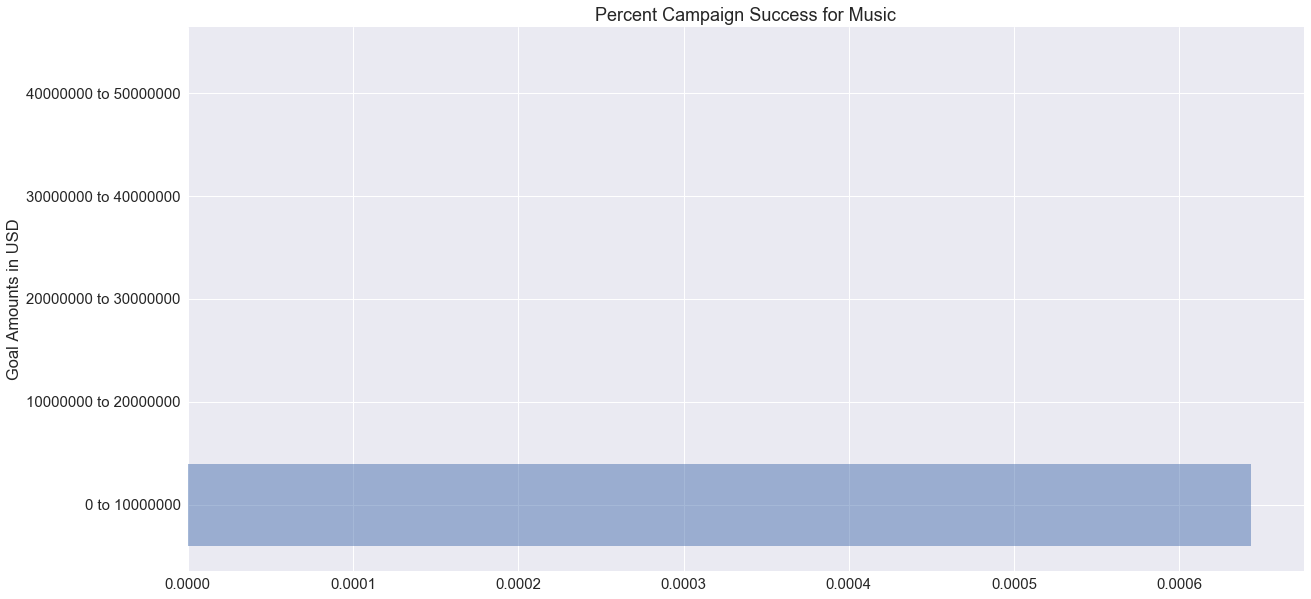

22500000.0


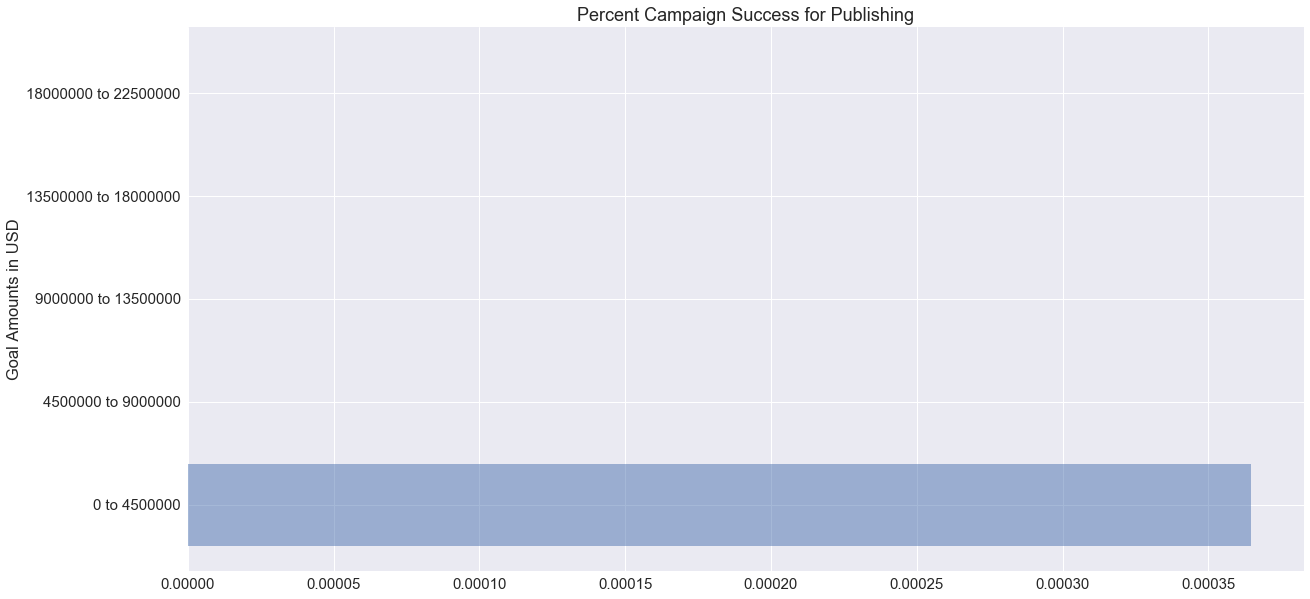

16610000.0


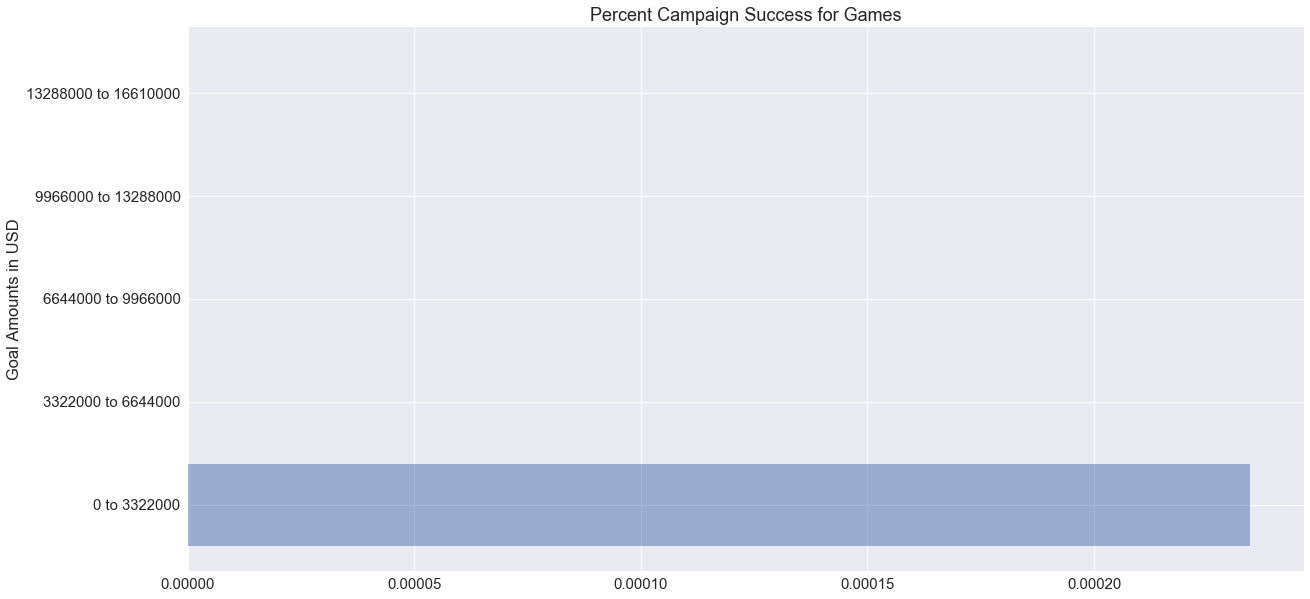

100000000.0


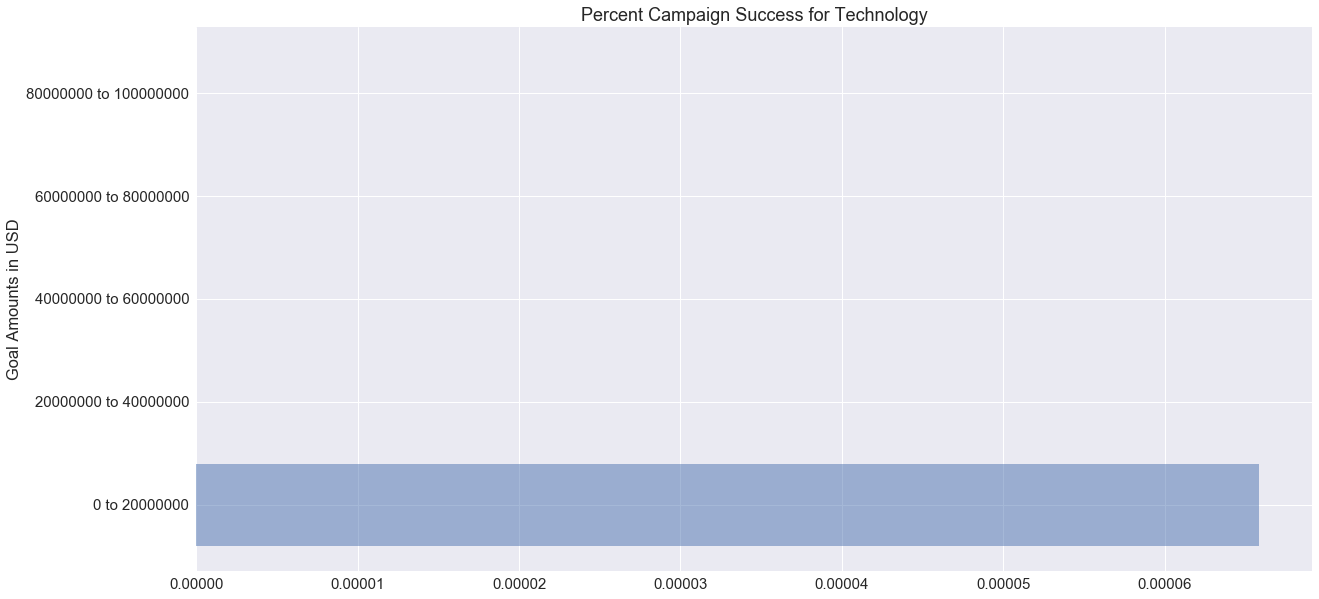

45000000.0


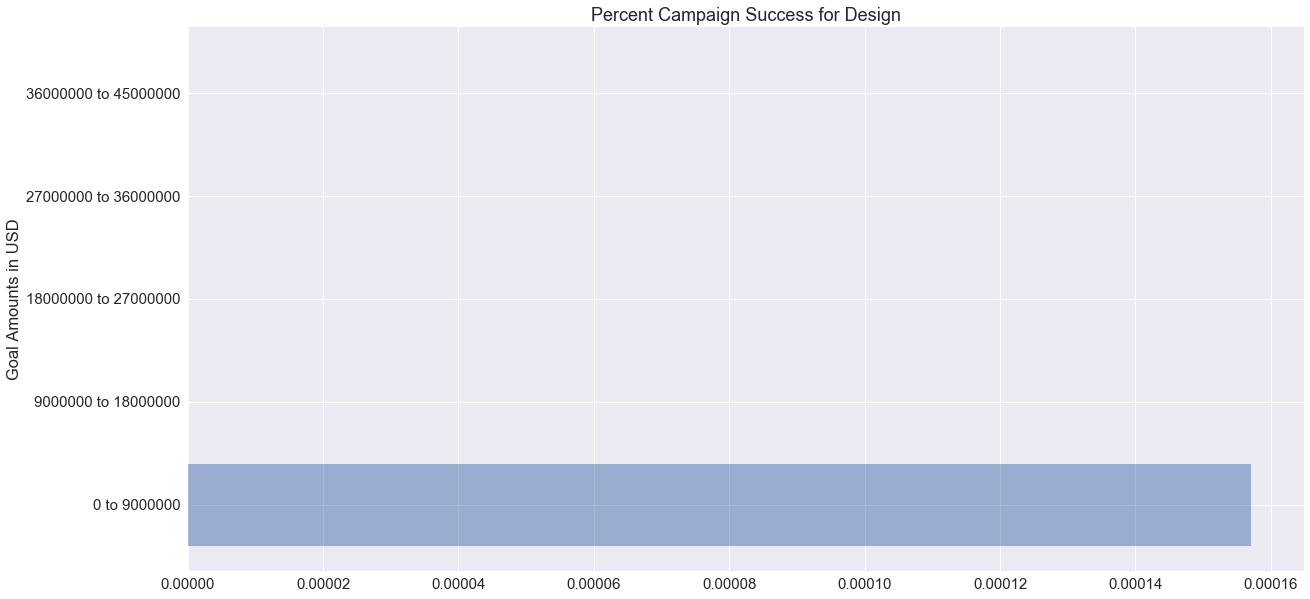

100000000.0


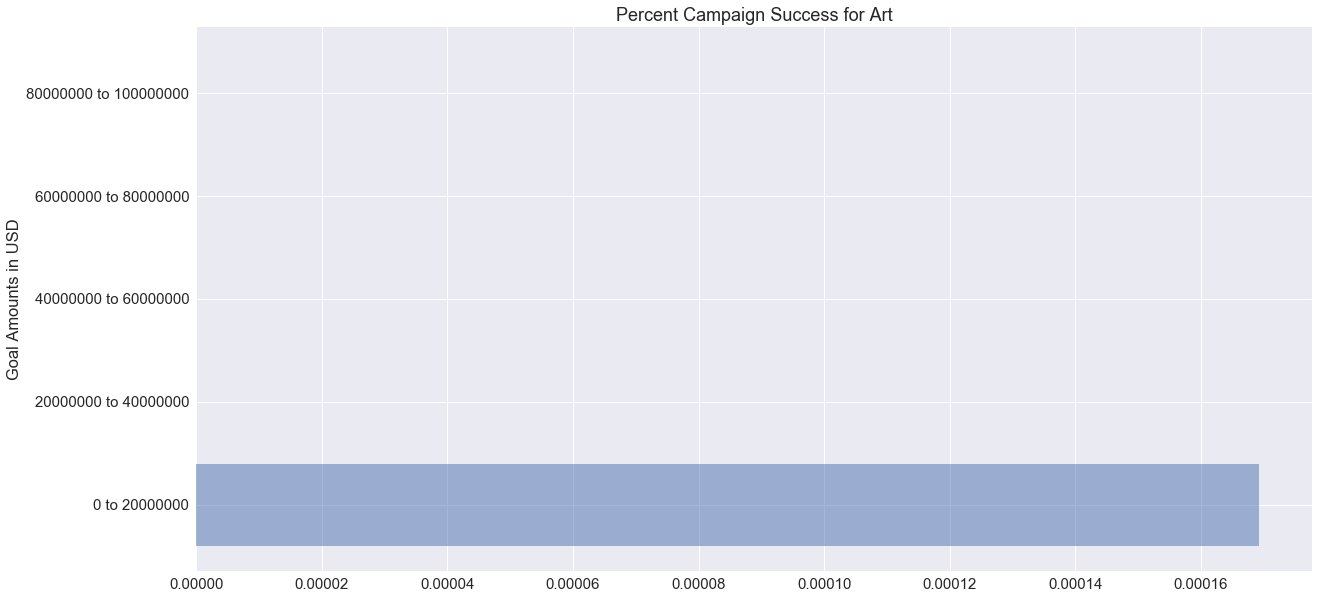

99000000.0


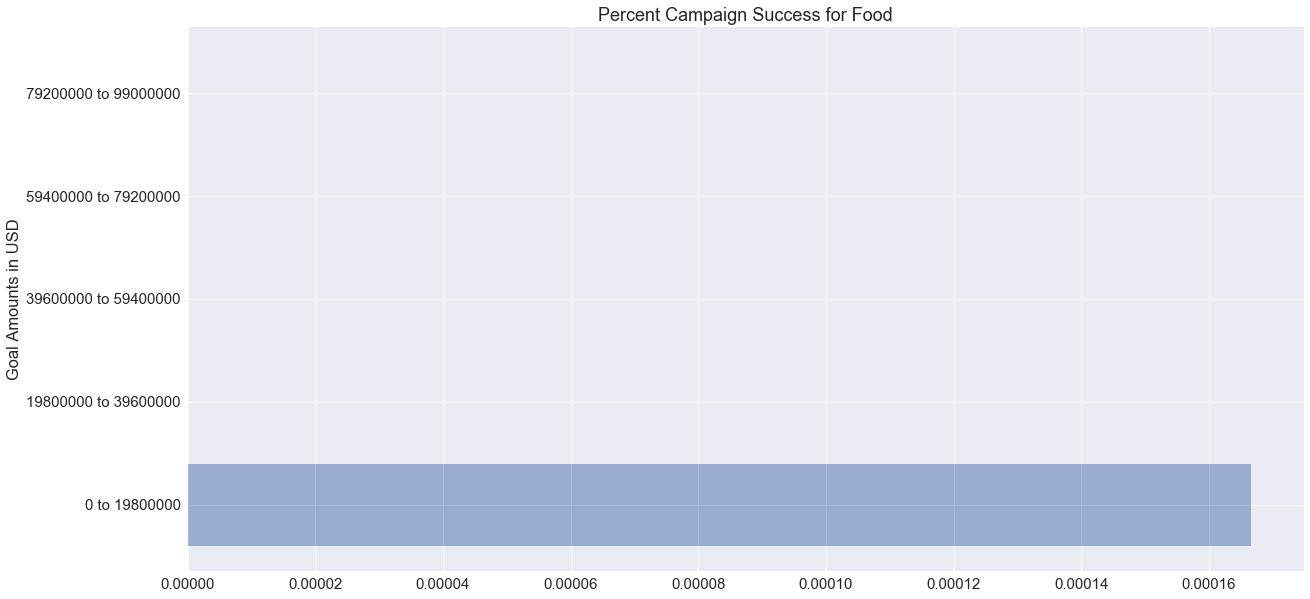

1500000.0


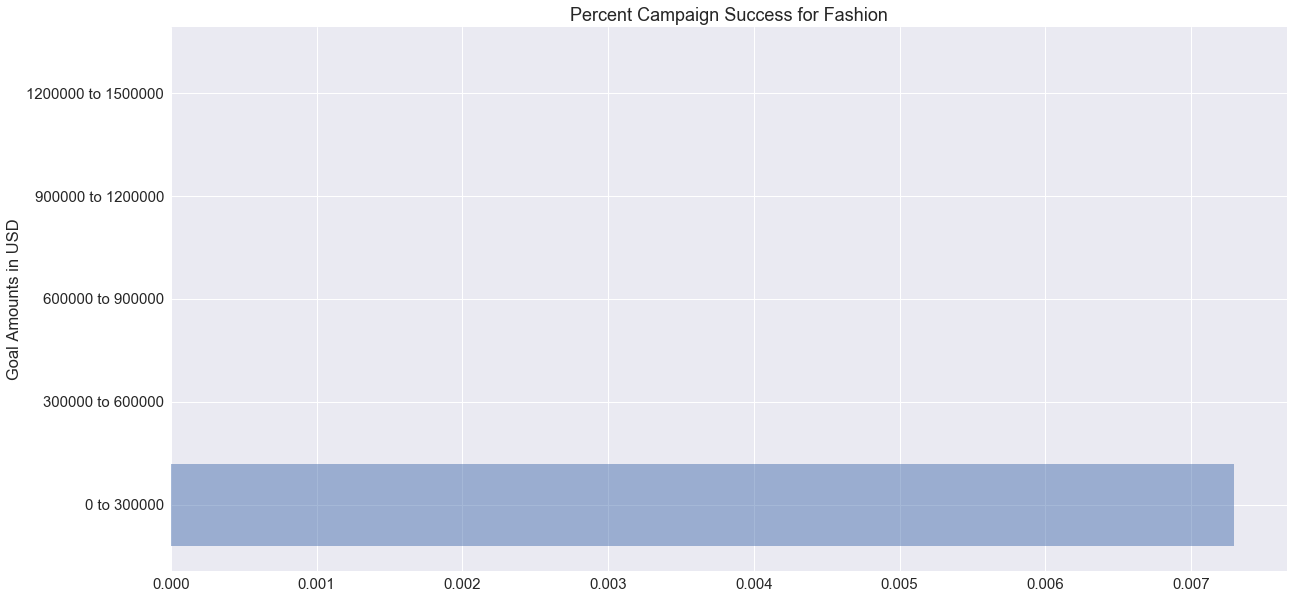

8000000.0


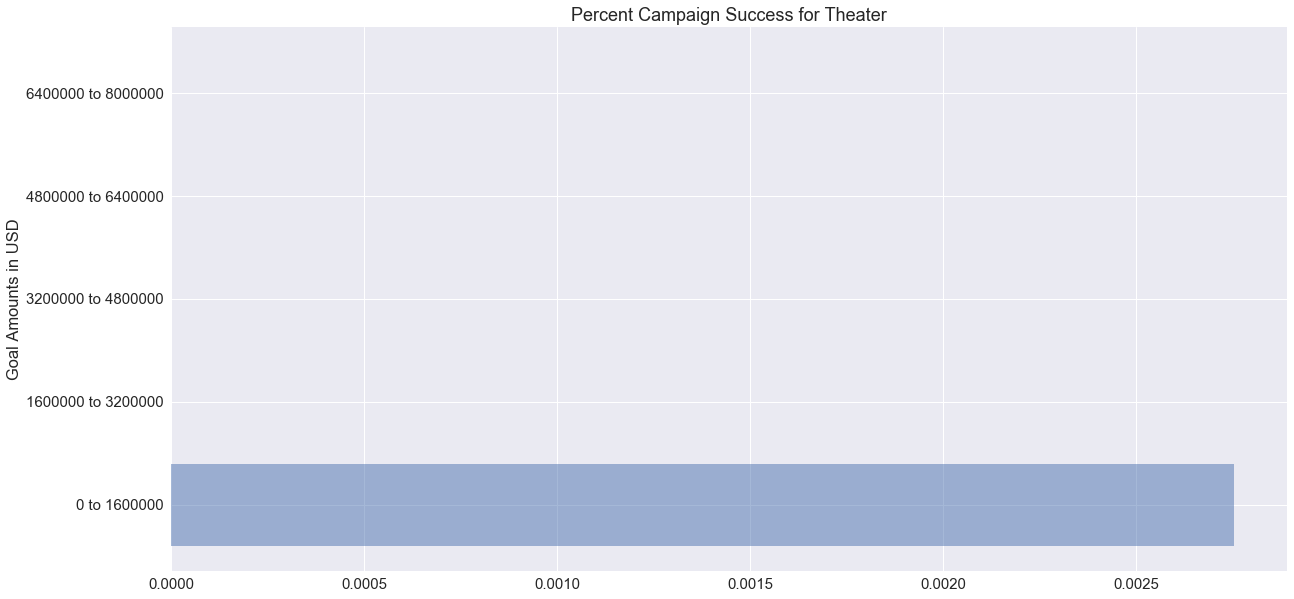

100000000.0


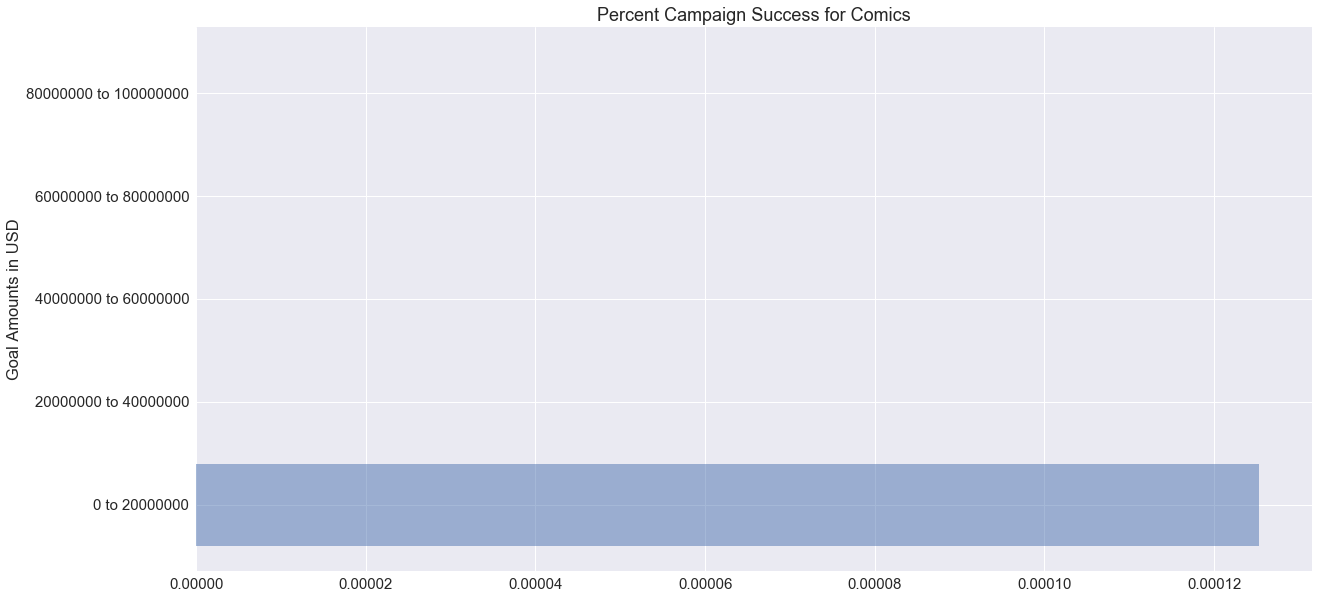

1000000.0


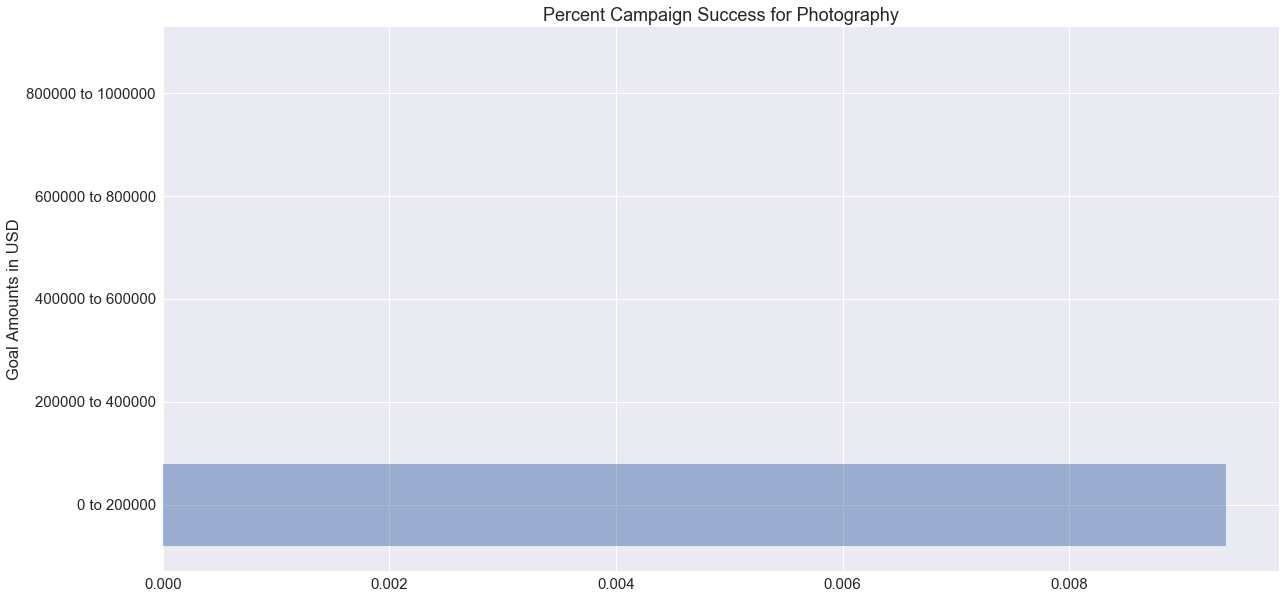

2500000.0


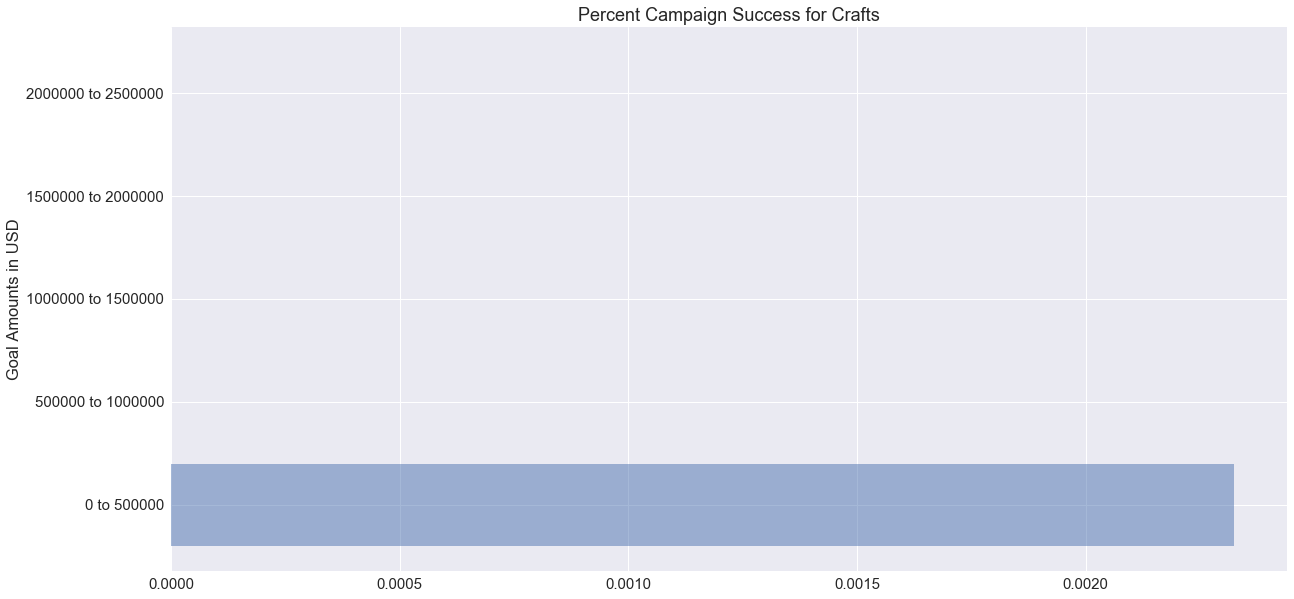

35000000.0


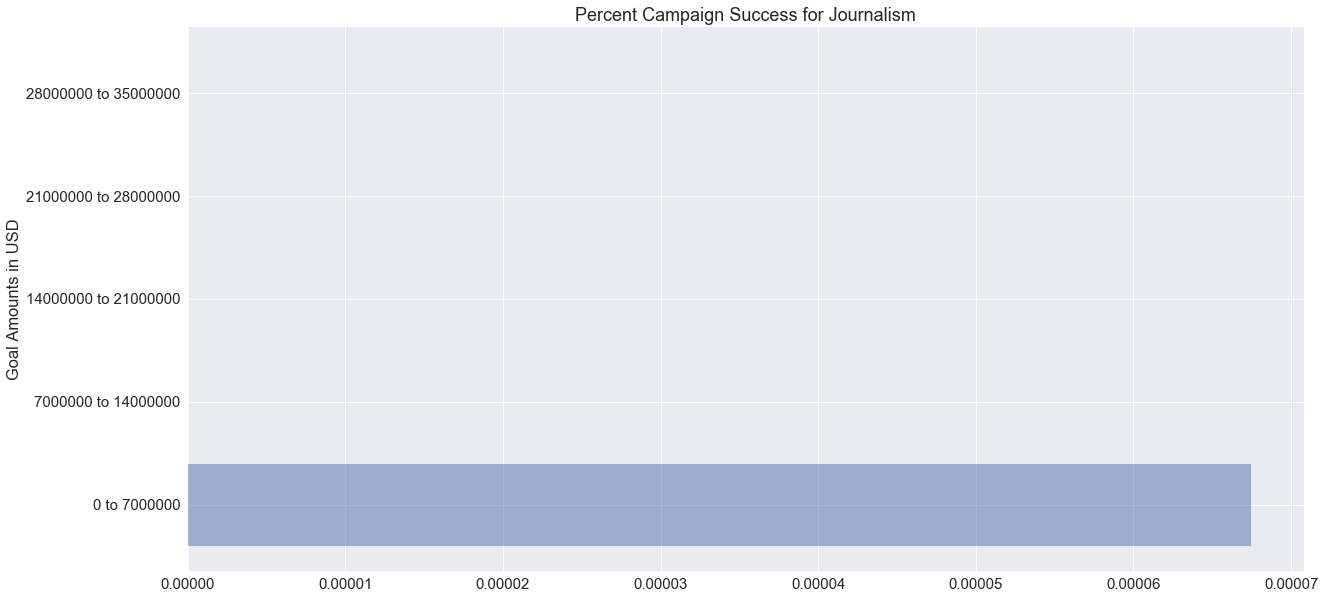

1000000.0


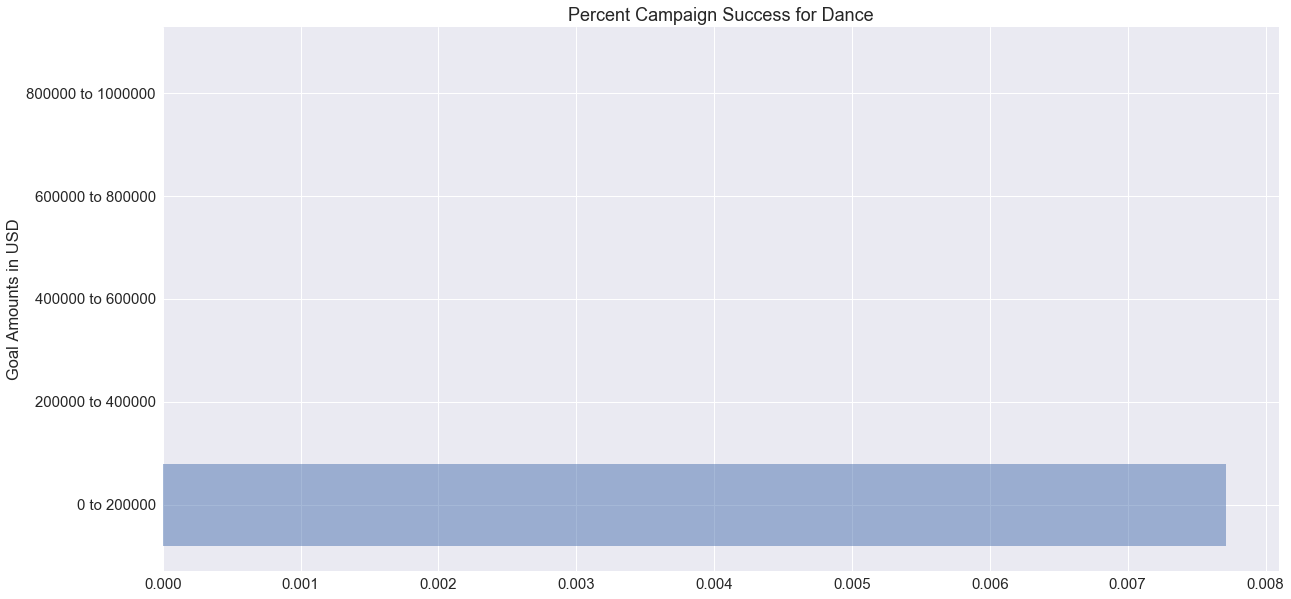

In [114]:
import numpy as np
from matplotlib import pyplot as plt

### Success by Goal: ALL GOALS

def success_by_goal_bar_plot(category):
    
    df = dataframe_filtered[dataframe_filtered['category'] == category]
    
    dataframe_modified = df.sort_values("goal", inplace=False, ascending=False)
    max_goal = dataframe_modified['goal'].iloc[0]
    print max_goal
    
    dataframe_modified = df.sort_values("goal", inplace=False, ascending=True)
    
    bucket_size = int(max_goal / 5)
    
    # df one has the lowest goal amounts, df five has the highest goal amounts
    df1 = dataframe_modified[0:bucket_size]
    df2 = dataframe_modified[bucket_size:2*bucket_size]
    df3 = dataframe_modified[2*bucket_size:3*bucket_size]
    df4 = dataframe_modified[3*bucket_size:4*bucket_size]
    df5 = dataframe_modified[4*bucket_size:5*bucket_size]
    
    df1_success = df1[df1['state'] == 'successful']
    df2_success = df2[df2['state'] == 'successful']
    df3_success = df3[df3['state'] == 'successful']
    df4_success = df4[df4['state'] == 'successful']
    df5_success = df5[df5['state'] == 'successful']
    
    df1_successes = df1_success.shape[0]
    df2_successes = df2_success.shape[0]
    df3_successes = df3_success.shape[0]
    df4_successes = df4_success.shape[0]
    df5_successes = df5_success.shape[0]
    
    objects = ("0" + " to " + str(bucket_size), str(bucket_size) + " to " + str(2*bucket_size), str(2*bucket_size) + " to " + str(3*bucket_size), str(3*bucket_size) + " to " + str(4*bucket_size), str(4*bucket_size) + " to " + str(5*bucket_size))
    y_pos = np.arange(len(objects))
    success_rate = [float(df1_successes)/bucket_size, float(df2_successes)/bucket_size, float(df3_successes)/bucket_size, float(df4_successes)/bucket_size, float(df5_successes)/bucket_size]
    
    plt.barh(y_pos, success_rate, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.ylabel('Goal Amounts in USD')
    plt.title('Percent Campaign Success for ' + category)

    plt.show()
    
success_by_goal_bar_plot('Film & Video')
success_by_goal_bar_plot('Music')
success_by_goal_bar_plot('Publishing')
success_by_goal_bar_plot('Games')
success_by_goal_bar_plot('Technology')
success_by_goal_bar_plot('Design')
success_by_goal_bar_plot('Art')
success_by_goal_bar_plot('Food')
success_by_goal_bar_plot('Fashion')
success_by_goal_bar_plot('Theater')
success_by_goal_bar_plot('Comics')
success_by_goal_bar_plot('Photography')
success_by_goal_bar_plot('Crafts')
success_by_goal_bar_plot('Journalism')
success_by_goal_bar_plot('Dance')


600.0
120


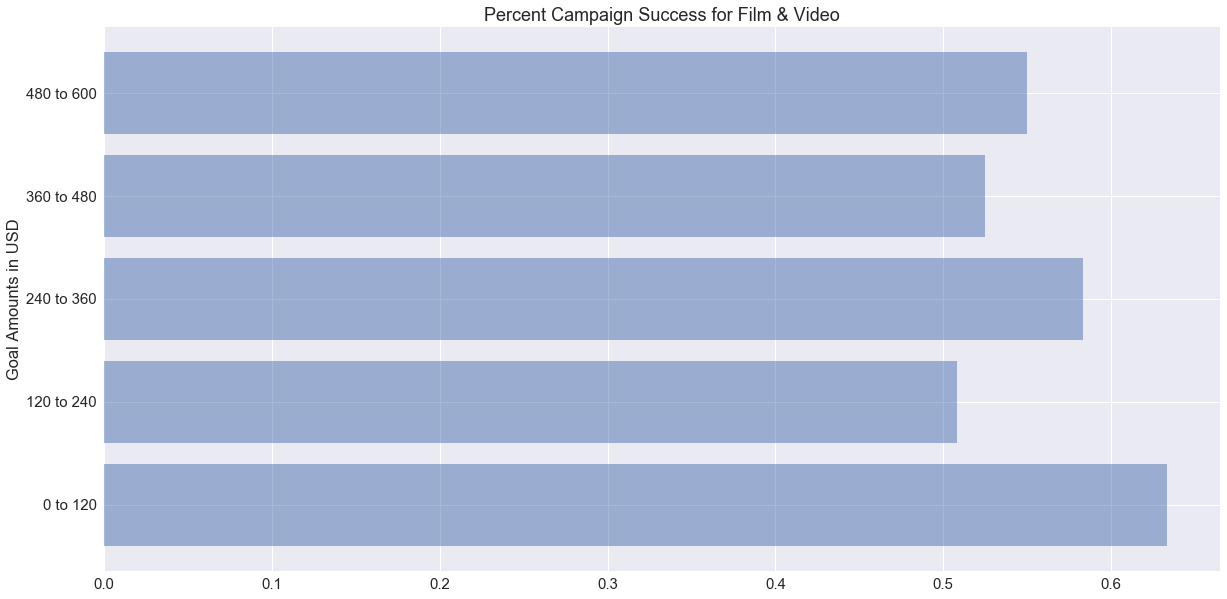

600.0
120


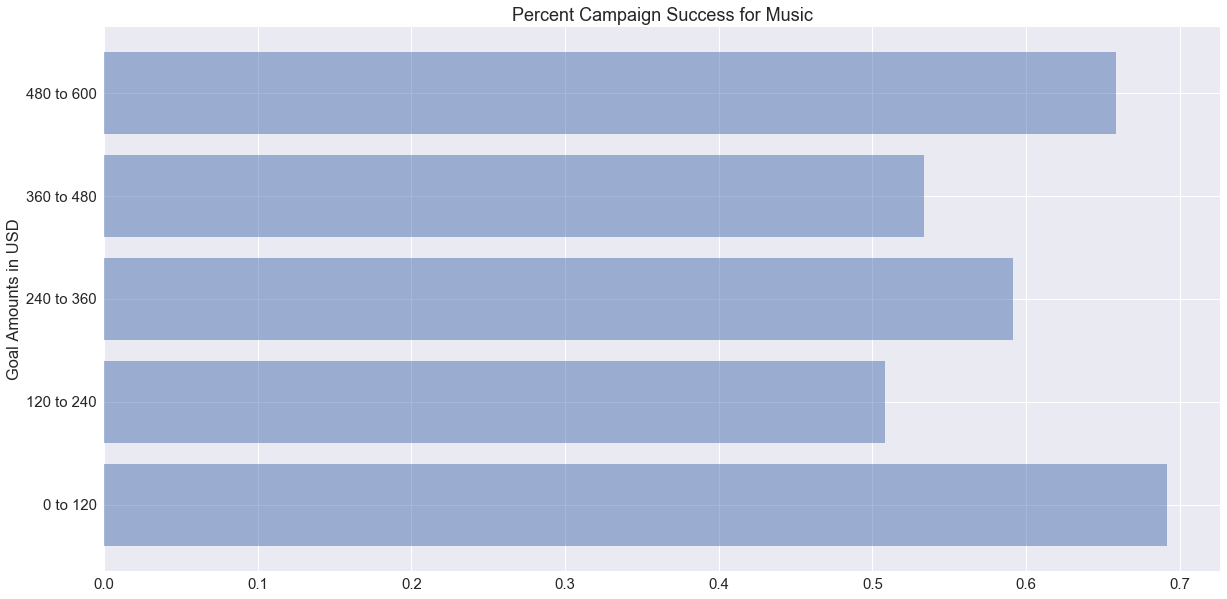

680.0
136


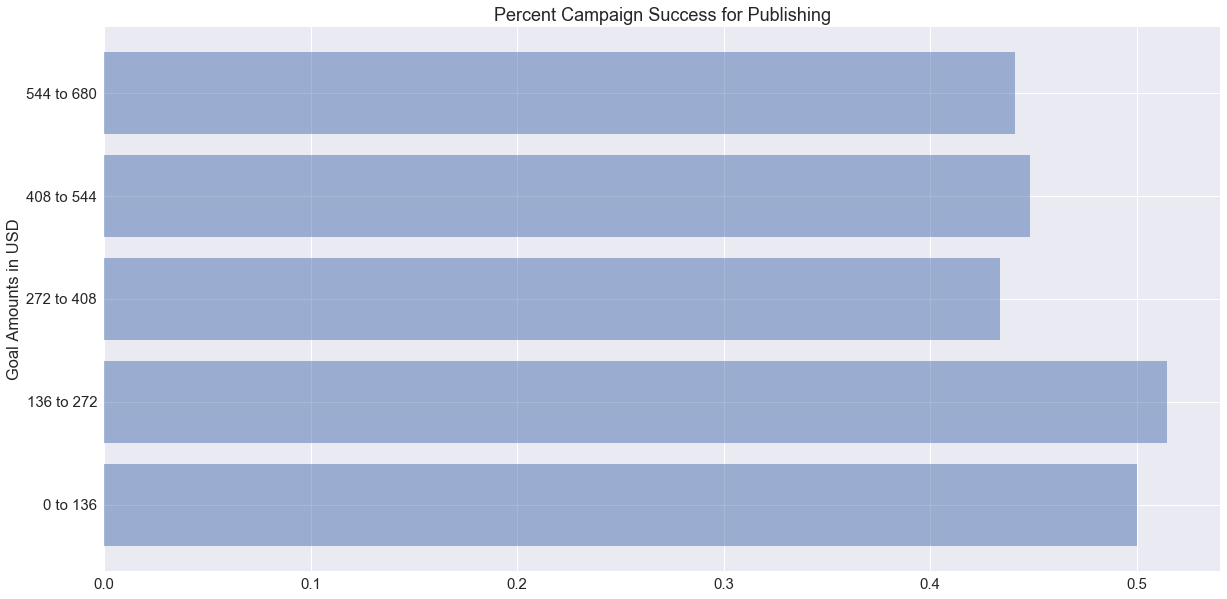

500.0
100


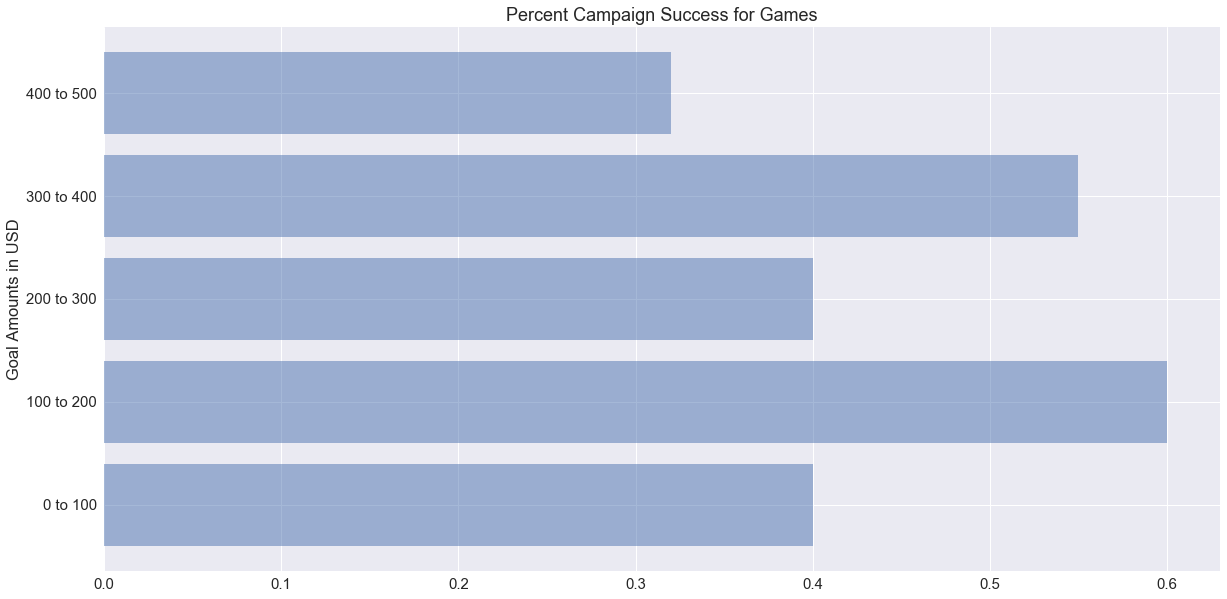

2000.0
400


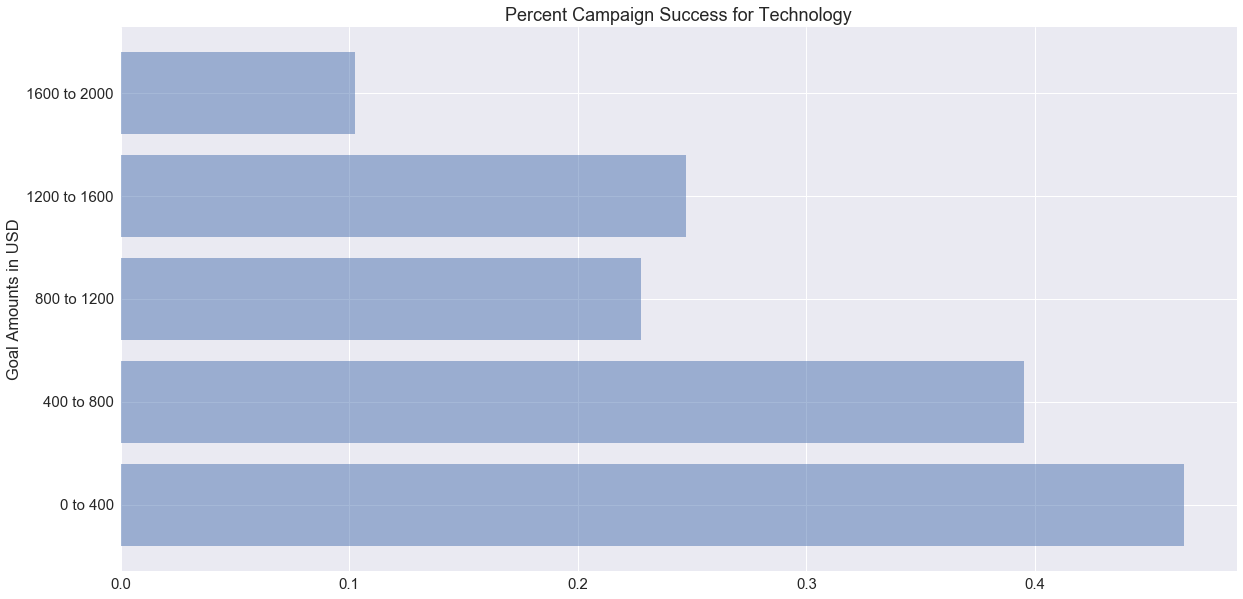

750.0
150


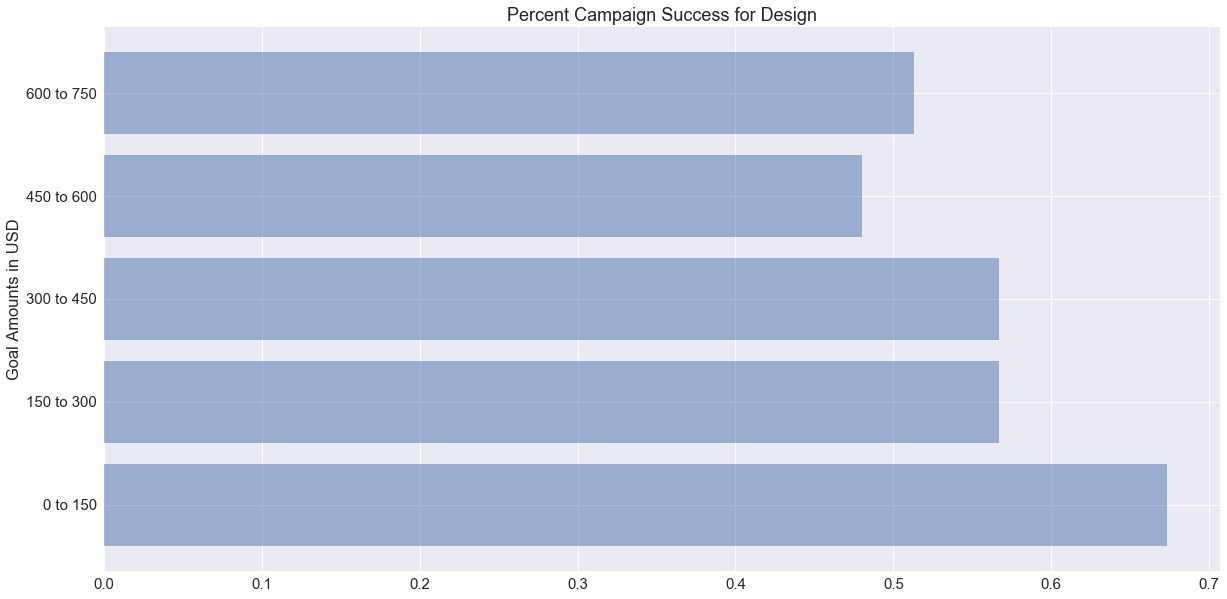

310.0
62


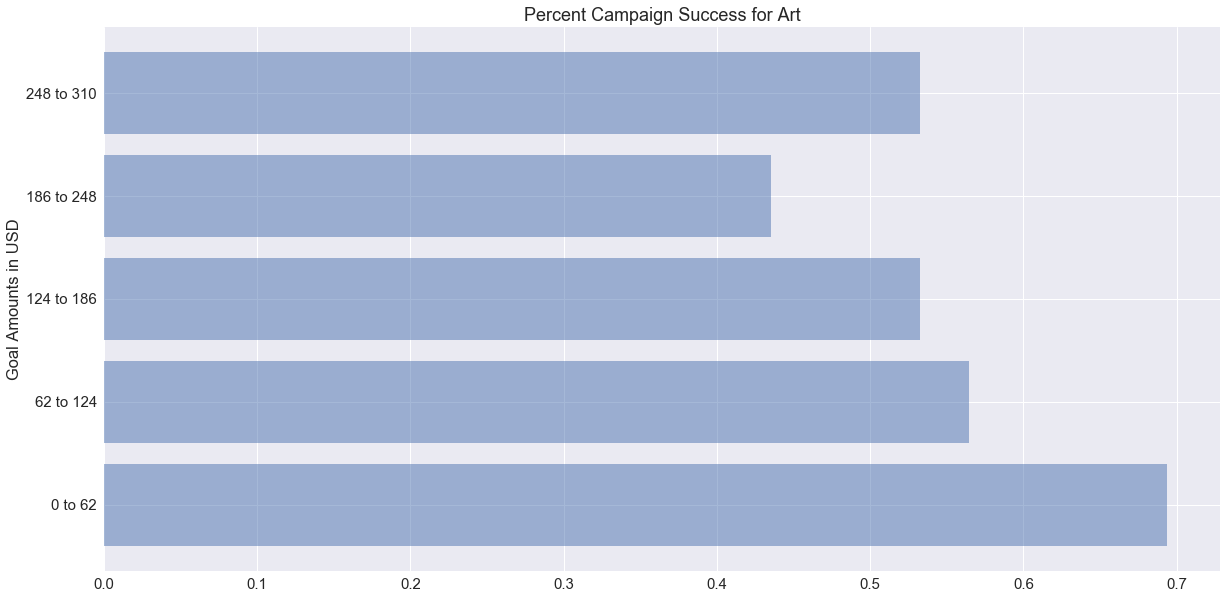

650.0
130


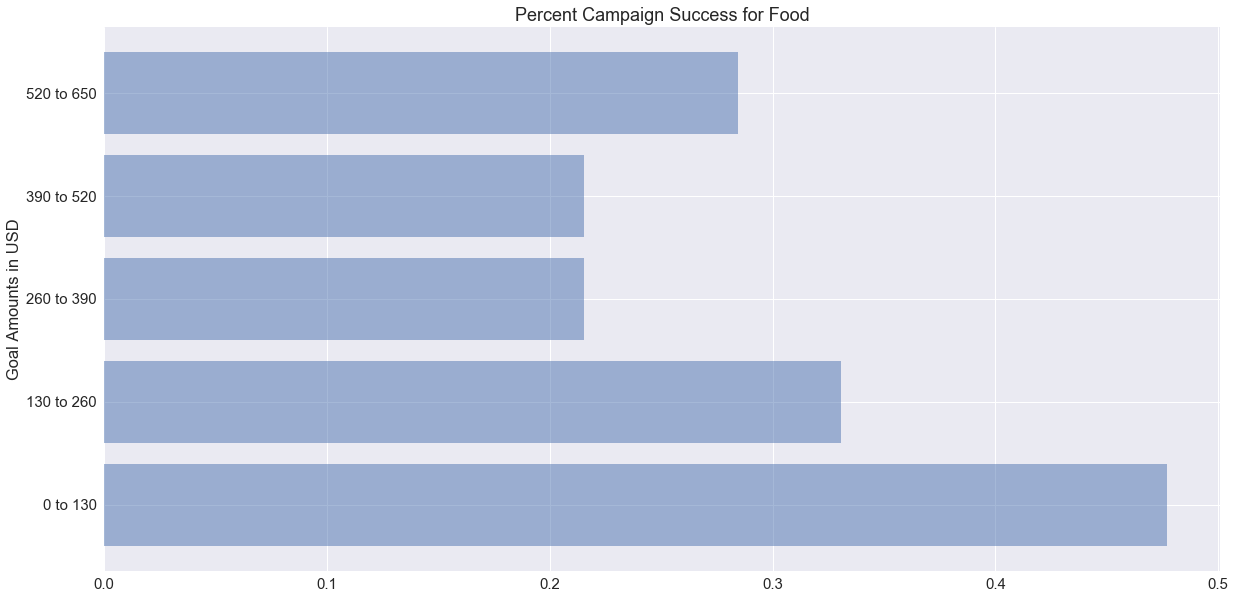

750.0
150


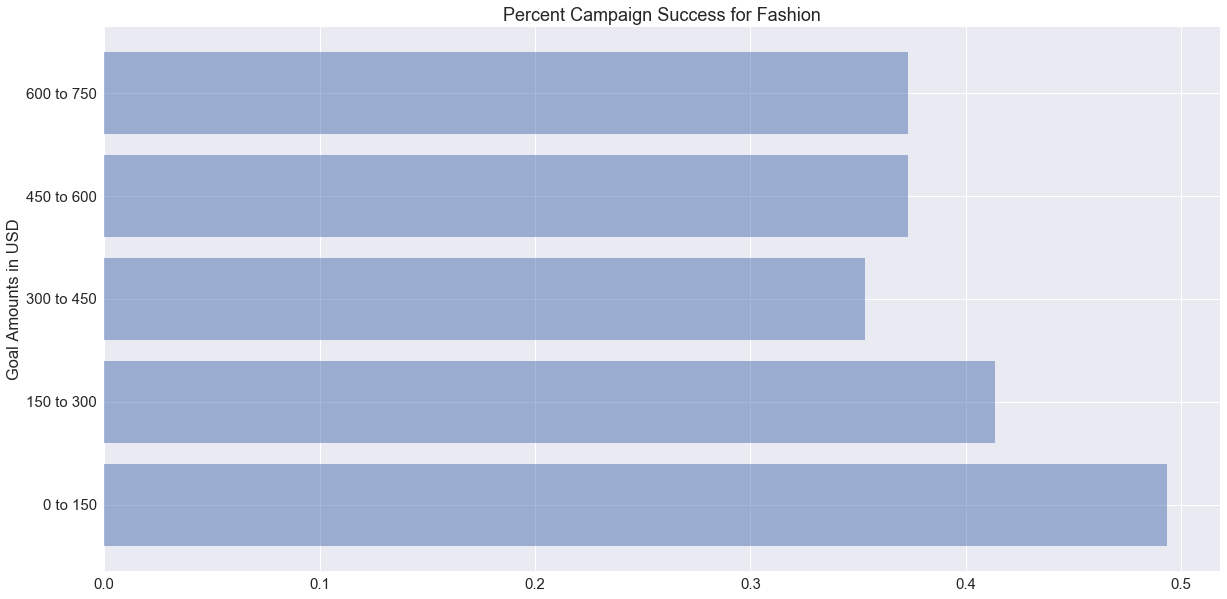

600.0
120


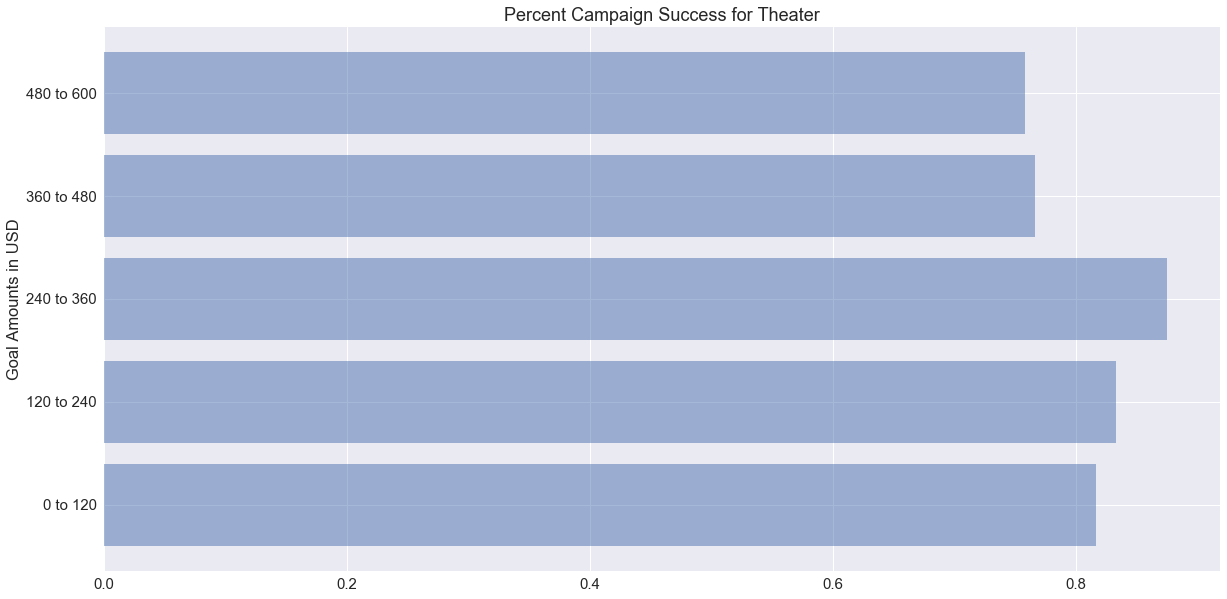

500.0
100


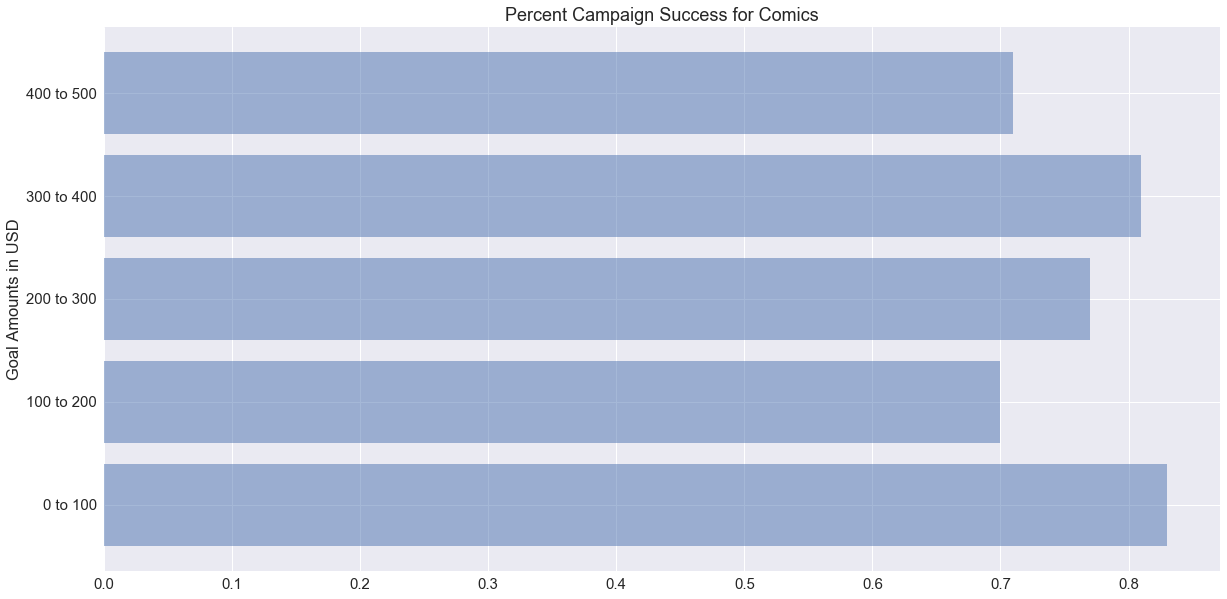

500.0
100


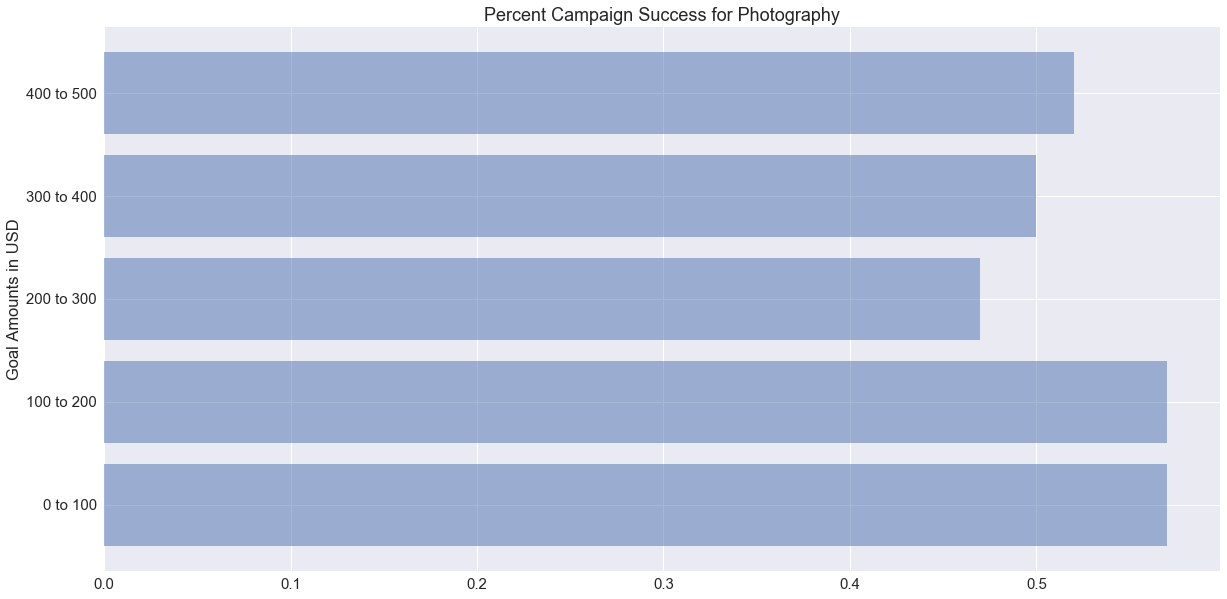

250.0
50


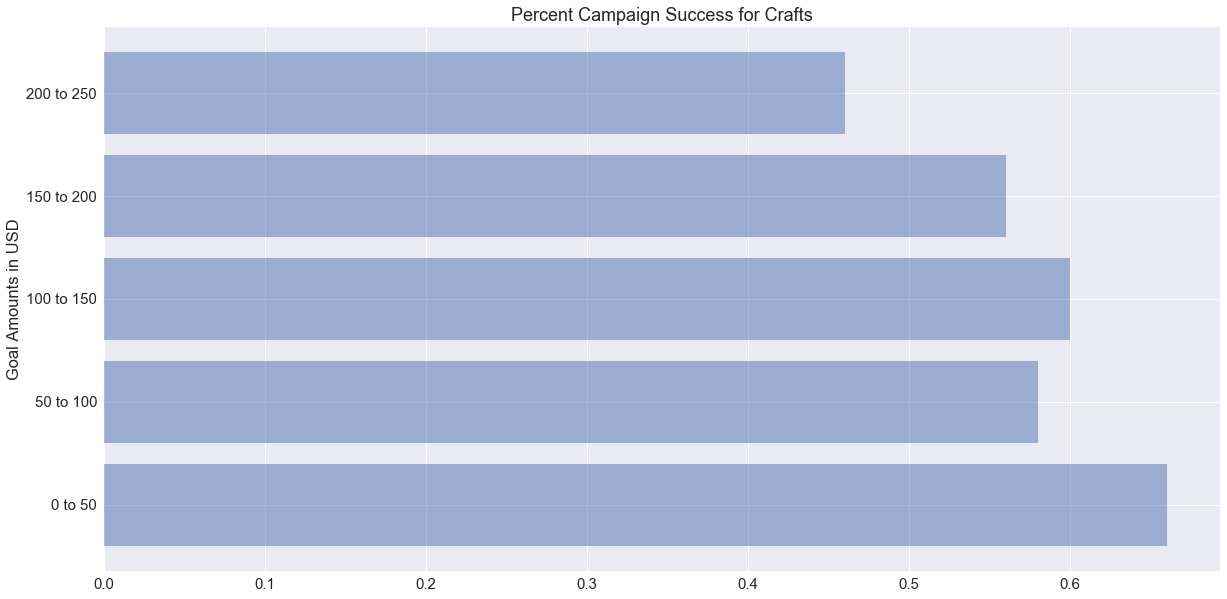

680.0
136


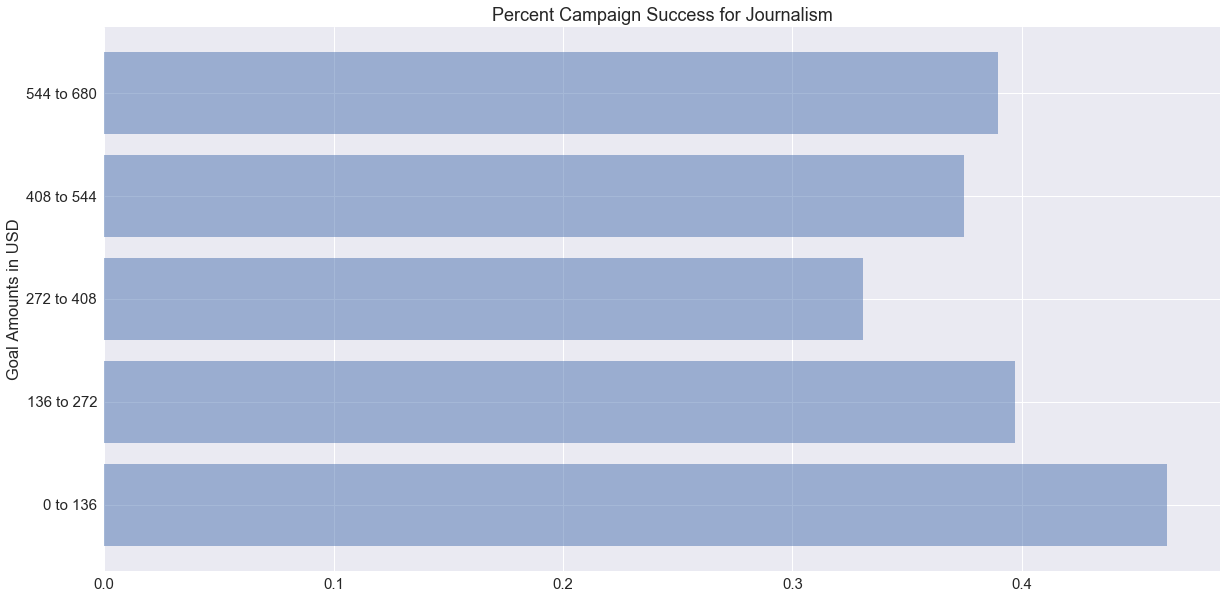

750.0
150


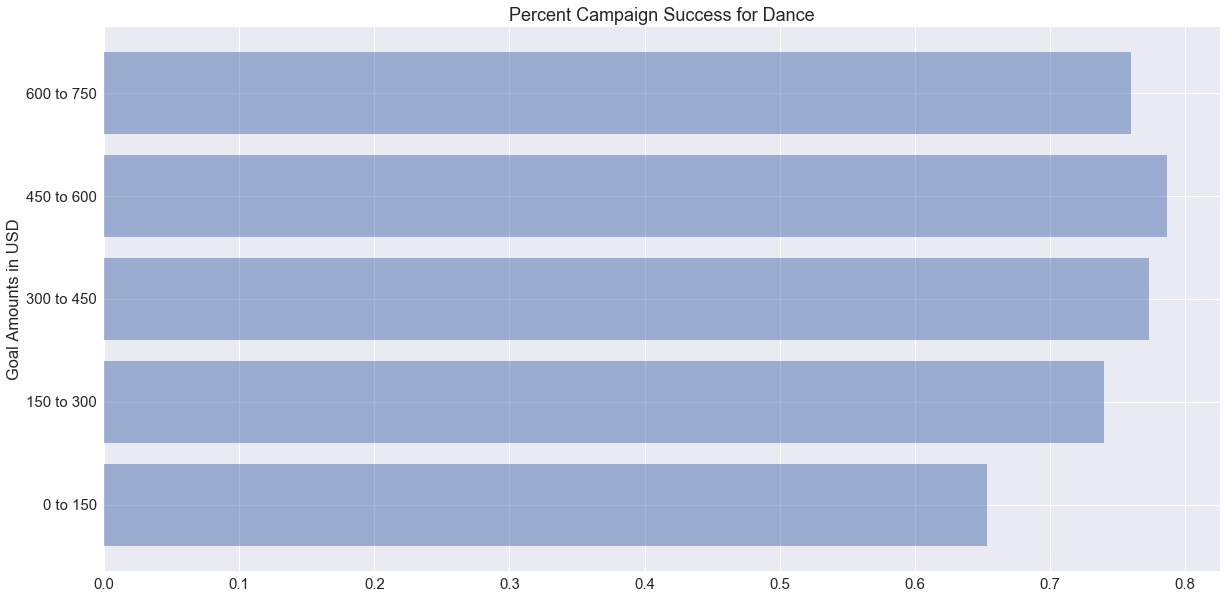

In [113]:
### Success by Goal: SMALLER GOALS

def success_by_goal_smaller_bar_plot(category):
    
    df = dataframe_filtered[dataframe_filtered['category'] == category]
    
    dataframe_modified = df.sort_values("goal", inplace=False, ascending=True)
    length = len(dataframe_modified)
    
    # just get the 1/10th with the lowest goal
    dataframe_cropped = dataframe_modified[0:length/10]
    length = len(dataframe_cropped)
    
    max_goal = dataframe_modified['goal'].iloc[length-1]
    
    bucket_size = int(max_goal / 5)
    
    # df one has the lowest goal amounts, df five has the highest goal amounts
    df1 = dataframe_modified[0:bucket_size]
    df2 = dataframe_modified[bucket_size:2*bucket_size]
    df3 = dataframe_modified[2*bucket_size:3*bucket_size]
    df4 = dataframe_modified[3*bucket_size:4*bucket_size]
    df5 = dataframe_modified[4*bucket_size:5*bucket_size]
    
    df1_success = df1[df1['state'] == 'successful']
    df2_success = df2[df2['state'] == 'successful']
    df3_success = df3[df3['state'] == 'successful']
    df4_success = df4[df4['state'] == 'successful']
    df5_success = df5[df5['state'] == 'successful']
    
    df1_successes = df1_success.shape[0]
    df2_successes = df2_success.shape[0]
    df3_successes = df3_success.shape[0]
    df4_successes = df4_success.shape[0]
    df5_successes = df5_success.shape[0]
    
    objects = ("0" + " to " + str(bucket_size), str(bucket_size) + " to " + str(2*bucket_size), str(2*bucket_size) + " to " + str(3*bucket_size), str(3*bucket_size) + " to " + str(4*bucket_size), str(4*bucket_size) + " to " + str(5*bucket_size))
    y_pos = np.arange(len(objects))
    success_rate = [float(df1_successes)/bucket_size, float(df2_successes)/bucket_size, float(df3_successes)/bucket_size, float(df4_successes)/bucket_size, float(df5_successes)/bucket_size]
    
    plt.barh(y_pos, success_rate, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.ylabel('Goal Amounts in USD')
    plt.title('Percent Campaign Success for ' + category)

    plt.show()

success_by_goal_smaller_bar_plot('Film & Video')
success_by_goal_smaller_bar_plot('Music')
success_by_goal_smaller_bar_plot('Publishing')
success_by_goal_smaller_bar_plot('Games')
success_by_goal_smaller_bar_plot('Technology')
success_by_goal_smaller_bar_plot('Design')
success_by_goal_smaller_bar_plot('Art')
success_by_goal_smaller_bar_plot('Food')
success_by_goal_smaller_bar_plot('Fashion')
success_by_goal_smaller_bar_plot('Theater')
success_by_goal_smaller_bar_plot('Comics')
success_by_goal_smaller_bar_plot('Photography')
success_by_goal_smaller_bar_plot('Crafts')
success_by_goal_smaller_bar_plot('Journalism')
success_by_goal_smaller_bar_plot('Dance')


How does the sentiment of the title impact success by category? Do certain categories fare better with a happy title vs a sad title? Or is there no difference across categories? What about the most popular subcategories?

How does duration impact success per category? What about the most popular subcategories?

How does currency impact success per category? What about the most popular subcategories?

How does country or currency impact success per category? What about the most popular subcategories?

Per category, how much do failed campaigns miss by as a percent of what they asked for? Which categories tend to “overask” or “underask” for money? What about the most popular subcategories?

How does the number of backers impact success per category? What about the most popular subcategories?

### Post-Exploration Work: "The Interesting Stuff"
More tasks tbd based on the results of the exploratory work.

For each category i, is there a good “threshold goal,” x_i, above which a success is y% likely? What are the x_i’s and y? What is the best goal amount to ask for per category?

Which subset of features is the most important in determining success for each category?

Determine the ideal traits of a campaign in each category.